# Simulating an Anisotropic Grain Structure

In [1]:
import fidimag
from scipy.spatial import cKDTree
import numpy as np
np.random.seed(10)

Here we set up a simple test system to show how to simulate magnetic grains which have different anisotropy orientations and strengths.

In [26]:
A=1.3e-11
Ms=8.6e5
n = 40
d = 5

mesh = fidimag.common.CuboidMesh(nx=n, ny=n, nz=1, dx=d, dy=d, dz=d, unit_length=1e-9, periodicity=(True, True, False))
sim = fidimag.micro.Sim(mesh, name="Grains")
sim.alpha = 1.0

In [27]:
# Create positions to be grain centres, and create a cKDTree to 
# perform Voronoi Tesselation

Ngrains = 5
grain_centres = np.random.uniform(0, n*d, (Ngrains, 2))
voronoi_kdtree = cKDTree(grain_centres)

# Define Anisotropy Strength
Ku = 1e6
# Generate random anisotropy axes
axes = np.random.uniform(-1, 1, (Ngrains, 3))
# Weight them towards +z - assume grains oriented along field cooled direction
axes[:, 2] += 1.0
# Normalise
axes /= np.linalg.norm(axes, axis=1)[:, np.newaxis]
# Generate a normal distribution of anisotropy strengths:
strengths = np.random.normal(Ku, Ku*0.2, Ngrains)

# We then use the cKDTree in two functions. We get the x, y position
# of each micromagnetic cell, and query the tree for the region that
# the cell sits in. The functions then return the axis and strength
# at that region index.

def K_axis(pos):
    x, y, z = pos
    _, test_point_regions = voronoi_kdtree.query(np.array([[x, y]]), k=1)
    region = test_point_regions[0]
    return axes[region]

def K_mag(pos):
    x, y, z = pos
    _, test_point_regions = voronoi_kdtree.query(np.array([[x, y]]), k=1)
    region = test_point_regions[0]
    return strengths[region]

In [28]:
sim.set_m((0, 0, 1), normalise=True)

sim.set_Ms(Ms)
anisotropy = fidimag.micro.UniaxialAnisotropy(K_mag, K_axis)
sim.add(anisotropy)
sim.add(fidimag.micro.UniformExchange(A))
sim.add(fidimag.micro.Demag(pbc_2d=True))

To check that this looks sensible, we plot the strength of the anisotropy across the whole sample in each direction:

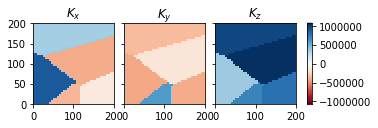

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

strength_x = anisotropy._axis[0::3].reshape(n, n) * anisotropy._Ku.reshape(n, n)
strength_y = anisotropy._axis[1::3].reshape(n, n) * anisotropy._Ku.reshape(n, n)
strength_z = anisotropy._axis[2::3].reshape(n, n) * anisotropy._Ku.reshape(n, n)

maxs = np.max([np.max(np.abs(strength_x)),
               np.max(np.abs(strength_y)),
               np.max(np.abs(strength_z))])



fig = plt.figure(figsize=(5, 3))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

axes = [axis for axis in grid]


axes[0].imshow(strength_x, origin='lower', cmap='RdBu', vmin=-maxs, vmax=maxs, extent=[0, n*d, 0, n*d])
axes[1].imshow(strength_y, origin='lower', cmap='RdBu', vmin=-maxs, vmax=maxs, extent=[0, n*d, 0, n*d])
im = axes[2].imshow(strength_z, origin='lower', cmap='RdBu', vmin=-maxs, vmax=maxs, extent=[0, n*d, 0, n*d])
axes[2].cax.colorbar(im)
axes[2].cax.toggle_label(True)

axes[0].set_title("$K_x$")
axes[1].set_title("$K_y$")
axes[2].set_title("$K_z$")

plt.savefig("Anisotropy.png", dpi=600)


We can see that we have a granular structure in the anisotropy. We now simply relax the system and plot the magnetisation:

In [30]:
sim.relax(dt=1e-12, stopping_dmdt=1.0, max_steps=10000, save_vtk_steps=10, printing=False)
print('Done')

Done


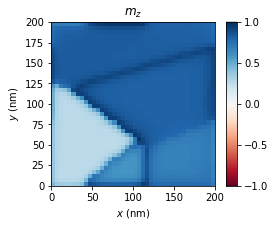

In [31]:
fidimag.common.plot(sim, component='z')

The remanent Magnetisation in the z-direction is then:

In [32]:
remanence = np.mean(sim.spin[2::3])*Ms
print(remanence)

605992.8775410325


In [34]:
605992.8775410325/521197.7929881685


1.1626927160737017